    L4 支持向量机

支持向量机也是一个二分类模型。它因最大化特征间隔而区别于感知机。

支持向量机可分为：线性可分、线性、非线性支持向量机。

分别对应对象为：线性可分、近似线性可分、线性不可分时的算法。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

对于一组二维的线性可分的对象

In [2]:
x1 = np.random.uniform(0,1,20)
diff1 = np.random.chisquare(2,20)
y1 = 2*x1 + 5 + diff1
df1 = pd.DataFrame((x1,y1),index = ['x1','x2']).T
df1['y'] = 1

x2 = np.random.uniform(0,1,20)
diff2 = np.random.chisquare(2,20)
y2 = 2*x2 + 3 - diff2
df2 = pd.DataFrame((x2,y2),index = ['x1','x2']).T
df2['y'] = -1

data = pd.concat([df1,df2],ignore_index = True)
data

,x1,x2,y
0,0.933084,7.872566,1
1,0.276236,5.843802,1
2,0.109101,5.587345,1
3,0.002496,5.204072,1
4,0.453277,6.742317,1
5,0.145919,8.583816,1
6,0.497049,6.063797,1
7,0.385640,7.513975,1
8,0.775493,6.720943,1
9,0.991862,7.066172,1


<function matplotlib.pyplot.show(close=None, block=None)>

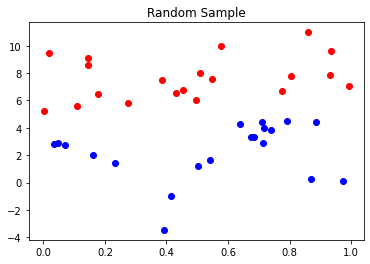

In [3]:
positive_x = data[['x1','x2']][data.y == 1]
negative_x = data[['x1','x2']][data.y != 1]
plt.scatter(positive_x['x1'] , positive_x['x2'] , color = 'r')
plt.scatter(negative_x['x1'] , negative_x['x2'] , color = 'b')
plt.title('Random Sample')
plt.show

支持向量机模型的对偶问题解法：

    凸二次规划问题：SMO（序列最小最优化算法）法

首先学习 坐标上升法：

In [4]:
def f(x):

    f = -(x[0]**2)-2*(x[1]**2)-3*(x[2]**2)+2*x[0]*x[1]+2*x[0]*x[2]-4*x[1]*x[2]+6
    
    return f

求解该函数的最大值

In [5]:
err = 1.0e-10
x = [1.0 , 1.0 , 1.0]
f_0 = f(x)

In [6]:
while 1:
    x[0] = x[1] + x[2]
    x[1] = x[0] / 2 - x[2]
    x[2] = x[0] / 3 - 2 * x[1] / 3
    
    f_t = f(x)
    
    if abs(f_t - f_0) < err:
        break
    f_0 = f_t

In [7]:
f_0

5.999999999836933

In [8]:
x

[-1.0426464811394665e-05, -1.0428327456543898e-05, 3.4767300338977098e-06]

SMO算法的思想与 坐标上升法 相同

SMO算法解支持向量机模型：

参考：https://blog.csdn.net/slx_share/article/details/80139487

In [9]:
class SVM:
    
    def __init__(self , ϵ = 1.0e-10 , maxstep = 2000 , 
                 C = 1.0 , kernel = 'linear' , kernel_par = 0.0):
        
        self.ϵ = ϵ                   #误差精度
        self.maxstep = maxstep       #最大迭代次数
        self.C = C                   #惩罚因子
        self.kernel = kernel         #核函数：linear：线性核函数；
                                     #       polynomials：多项式核函数；
                                     #       gaussian：高斯核函数                          
        self.kernel_par = kernel_par #核函数参数
        
        self.X = None                #训练集的特征
        self.Y = None                #训练集的标签
        self.N = None                #训练集的样本量
        self.a = None                #[1xn] 拉格朗日乘子
        self.b = 0.0                 #阀值
        
        self.err = None              #[1xn] 每个样本的预测误差

        
    def init_parameters(self , x_data , y_data):
        
        #初始化参数
        
        self.X = x_data
        self.Y = y_data
        self.N = len(y_data)
        self.a = np.zeros(self.N)
        
        self.err = -self.Y
        return 
    
    
    def kernel_function(self , x1 , x2):
        
        #核函数
        
        if self.kernel == 'linear':
            return np.dot(x1 , x2)
        
        elif self.kernel == 'polynomials':
            dot1 = np.dot(x1 , x2)
            return np.sum((dot1 + 1) ** self.kernel_par)
        
        elif self.kernel == 'gaussian':
            return np.sum(np.exp(-np.square(x1 - x2)
                                 /(2 * (self.kernel_par ** 2))))
    
        else : exit('kernel function error')
            
    
    def KKT_condition(self , y , err , a):
        
        # 判断是否满足KTT条件
        
        r = y * err
        
        # （r<0,yg<1 , alpha=C） 或 （r>0,yg>1 , alpha=0）则符合
        
        if (r < -self.ϵ and a < self.C) or (r > self.ϵ and a > 0):
            return False
        
        return True
    
    
    def select_a2(self , ind1):
        
        #挑选第二个a,返回其索引
        #《统》P147第一种方法
        
        E1=self.err[ind1]
        ind2 = None
        max_diff = 0.0 #初始化最大的|E1-E2|
        exist_errors = list(np.nonzero(self.err)[0]) #存在预测误差的样本索引
        
        if len(exist_errors) > 1:
            for i in exist_errors:
                if i == ind1:
                    #ind2不与ind1相同
                    continue
                    
                diff = abs(self.err[i] - E1)
                
                if diff > max_diff:
                    max_diff = diff
                    ind2 = i
       
        return ind2
    
    
    def update(self , ind1 , ind2):
        
        #更新 a , err , E , b
        #《统》P148
        
        a_1_old = self.a[ind1]
        a_2_old = self.a[ind2]
        
        y_1 = self.Y[ind1]
        y_2 = self.Y[ind2]
        
        if y_1 == y_2:
            L = max(0 , a_2_old + a_1_old - self.C)
            H = min(self.C , a_2_old + a_1_old)
            
        else:
            L = max(0 , a_2_old - a_1_old)
            H = min(self.C , self.C + a_2_old - a_1_old)
        
        if L == H:
            return 0
        
        E1 = self.err[ind1]
        E2 = self.err[ind2]
        
        K11 = self.kernel_function(self.X[ind1] , self.X[ind1])
        K12 = self.kernel_function(self.X[ind1] , self.X[ind2])
        K22 = self.kernel_function(self.X[ind2] , self.X[ind2])
        
        #更新a2
        η = K11 + K22 - 2 * K12
        a_2_new_unc = a_2_old + y_2 * (E1 - E2) / η
        
        if a_2_new_unc > H:
            a_2_new = H
        elif a_2_new_unc < L:
            a_2_new = L
        else:
            a_2_new = a_2_new_unc
            
        #更新a1
        a_1_new = a_1_old + y_1 * y_2 * (a_2_old - a_2_new)
        
        #放进a里
        self.a[ind1] = a_1_new
        self.a[ind2] = a_2_new
        
        #更新b
        b_1_new = -E1 - y_1 * K11 * (a_1_new - a_1_old) - y_2 * K12 * (a_2_new - a_2_old) + self.b
        b_2_new = -E2 - y_1 * K12 * (a_1_new - a_1_old) - y_2 * K22 * (a_2_new - a_2_old) + self.b
        
        if 0 < a_1_new < self.C:
            self.b = b_1_new
        elif 0 < a_2_new < self.C:
            self.b = b_2_new
        else :
            self.b  = (b_1_new + b_2_new) / 2
            
        #更新err
        self.err[ind1] = np.sum(self.Y * self.a * self.kernel_function(self.X , self.X[ind1])) + self.b - self.Y[ind1]
        self.err[ind2] = np.sum(self.Y * self.a * self.kernel_function(self.X , self.X[ind2])) + self.b - self.Y[ind2]
        return 1
    
    
    def learn(self , x_data , y_data):
        
        #SMO算法训练数据集
        #《统》P149
        
        self.init_parameters(x_data , y_data)

        step = 0
        
        while step < self.maxstep:
            for i in range(self.N):
                
                #挑选第一个a1
                if not self.KKT_condition(y_data[i] , self.err[i] , self.a[i]):
                    ind1 = i
                    
                    #挑选a2
                    ind2 = self.select_a2(ind1)
                    
                    #更新
                    self.update(ind1 , ind2)
            
            step += 1
        
        
        return self.a
    
    
    def predict(self , x):
        
        #利用训练过的模型预测
        
        g=np.sum(self.a * self.y
                 * self.kernel_function(self.x , x))
        
        return np.sign(g + self.b)
                
        

In [10]:
svm = SVM(ϵ = 1.0e-10 , maxstep = 2000 , 
          C = 0.5 , kernel = 'linear' , kernel_par = 0.0)

In [11]:
x_data = np.array(data[['x1' , 'x2']])
y_data = np.array(data['y'])

In [12]:
a= svm.learn(x_data , y_data)

In [13]:
w1,w2 = np.sum(a[i] * y_data[i] * x_data[i] for i in range(len(y_data)))

<ipython-input-13-09b54b6ccec5>:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  w1,w2 = np.sum(a[i] * y_data[i] * x_data[i] for i in range(len(y_data)))


In [14]:
i = np.nonzero(a)[0][0]

In [15]:
b = y_data[i] - np.sum(y_data[j] * a[j] * np.dot(x_data[j] , x_data[i]) for j in range(len(y_data)))

<ipython-input-15-7ee98dcb1574>:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  b = y_data[i] - np.sum(y_data[j] * a[j] * np.dot(x_data[j] , x_data[i]) for j in range(len(y_data)))


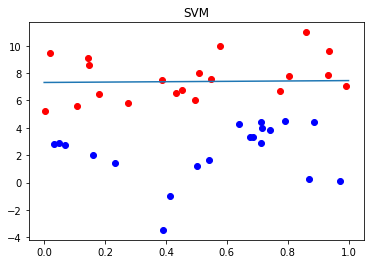

In [16]:
x1 = np.linspace(0,1)
x2 = - ( w1 * x1 + b ) / w2
plt.plot(x1 , x2)
positive_x = data[['x1','x2']][data.y == 1]
negative_x = data[['x1','x2']][data.y != 1]
plt.scatter(positive_x['x1'] , positive_x['x2'] , color = 'r')
plt.scatter(negative_x['x1'] , negative_x['x2'] , color = 'b')
plt.title('SVM')
plt.show()